(Notebook modified from https://course.ccs.neu.edu/ds4440f20/)

**Instructions:** Answer the four questions below in the notebook itself. Submit your notebook on Canvas and a pdf printout.


### Convolutional Neural Networks

A simple example to demonstrate the ideas introduced in lecture and (relatively simple exercises)

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

In [2]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Q1. Write code to answer the questiosn below:**
- How many images are there in `train_data` and `test_data`?
- How many labels are there in `train_data`?
- What is the height and width of each image?

The answer to Q1 is the code that outputs the answers to the questions above.

In [3]:
print("The number of images in the train data is: %d" %len(train_set))
print("The number of images in the test data is: %d" %len(test_set))
print("The number of labels in the train data is: %d" %len(train_set.classes))
print("The height and width of each image is: ", train_set.data.shape[1:])

The number of images in the train data is: 60000
The number of images in the test data is: 10000
The number of labels in the train data is: 10
The height and width of each image is:  torch.Size([28, 28])


In [4]:
# Note: the `out_channels` argument is what we referred to as the number of
# filters in lecture. 
conv_layer = nn.Conv2d(in_channels=1, out_channels=5, stride=2, kernel_size=3)

In [5]:
conv_layer.weight.shape

torch.Size([5, 1, 3, 3])

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size, 
                                          shuffle=False)

**Q2. Answer the following questions (no code required):**

- What is the meaning of `shuffle=True and shuffle=False**
- Why do we shuffle the train data?
- Why don't we shuffle the test data?

The answer to Q2 is a few sentences, no code required.

In [ ]:
'''
When you use ‘shuffle=True’, it randomizes the order of the data between each
batch or between each epoch, depending on how you set it. When you use
‘shuffle=False’, it does not do anything to change the order of the data.
The reason we shuffle the training data is to make sure that each data input is
independent of the others. For example, the data might be ordered according to
certain classes. Thus, in order to avoid unwanted bias in the learning, it is
important for the training data to be shuffled as it is given as the input.
By contrast, one does not need to shuffle the test data. Shuffling the test
data is irrelevant, because the model does not use the test data to update the
parameters.
'''

### Full example

Derived from: [https://github.com/yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial).

In [8]:
device = 'cuda'
num_epochs = 5
num_classes = 10
learning_rate = 0.001

# A simple convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

with torch.no_grad():
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_preds.extend(predicted)
    ##
    

Epoch [1/5], Step [100/1875], Loss: 0.9885
Epoch [1/5], Step [200/1875], Loss: 0.1656
Epoch [1/5], Step [300/1875], Loss: 0.7042
Epoch [1/5], Step [400/1875], Loss: 0.4842
Epoch [1/5], Step [500/1875], Loss: 0.2350
Epoch [1/5], Step [600/1875], Loss: 0.6708
Epoch [1/5], Step [700/1875], Loss: 0.3543
Epoch [1/5], Step [800/1875], Loss: 0.2446
Epoch [1/5], Step [900/1875], Loss: 0.1913
Epoch [1/5], Step [1000/1875], Loss: 0.5139
Epoch [1/5], Step [1100/1875], Loss: 0.3176
Epoch [1/5], Step [1200/1875], Loss: 0.2238
Epoch [1/5], Step [1300/1875], Loss: 0.4015
Epoch [1/5], Step [1400/1875], Loss: 0.5141
Epoch [1/5], Step [1500/1875], Loss: 0.2940
Epoch [1/5], Step [1600/1875], Loss: 0.2257
Epoch [1/5], Step [1700/1875], Loss: 0.2651
Epoch [1/5], Step [1800/1875], Loss: 0.3830
Epoch [2/5], Step [100/1875], Loss: 0.2655
Epoch [2/5], Step [200/1875], Loss: 0.2549
Epoch [2/5], Step [300/1875], Loss: 0.2692
Epoch [2/5], Step [400/1875], Loss: 0.2215
Epoch [2/5], Step [500/1875], Loss: 0.3195
Ep

**Q3. Answer the following question:** 

The implementation above uses Batch Normalization (`nn.BatchNorm2d(16),`)

- Explain Batch Normalization with your own words. Get inspiration from here: https://d2l.ai/chapter_convolutional-modern/batch-norm.html (or any other source, but use your own words and an example)

The answer to Q3 does not require any code, a good answer will have an intu explanation and an example (toy example is fine).

In [ ]:
'''
Initially, normalization is typically applied to the input data, so that various
features can be placed on the same scale. For instance, suppose that one of the
features pertaining to the data is the number of minutes that a person exercises
in a year. And suppose that another feature is the person’s age. And yet another
feature is the person’s BMI. The values for these three features are situated
within three scales that largely differ from one another. Thus, in order to
increase the training efficiency of the model, it is a common practice to
situate all three ranges of values within a singe scale, commonly one that
ranges from 0 to 1. This use of normalization with respect to the inputs to the
model can also be applied to the hidden layers of the model. When normalization
is applied to the hidden layers, it is known as batch normalization. For
example, suppose that with respect to the input data, we normalize the annual
minutes exercised, the age, and the BMI so that all of these three features are
represented on a scale from 0 to 1. Then, further suppose that we train a
particular neural network with a batch size of 30. Thus, after every 30 inputs,
the model will revise its parameters. However, when the model does this, it may
cause certain values in the hidden layers to be distributed in a way that is
not efficient to learning (e.g., in much the same way that the original input
values might be distributed in an inefficient way due to differences in how the
features are scaled). Given this, it is often useful to apply normalization to
the hidden layers after each batch, i.e., the process known as batch
normalization. This allows the values of the hidden layers to be more stable,
and thus it reduces the extent to which updating the parameters in earlier
layers affects the distribution of values that a given hidden layer receives
and learns on. The final result leads to a model that trains more efficiently
on the data.
'''

**Q4. Answer the questions below:**

You will do a qualitative analysis beyond stating that the accuracy in the test set is `90.27%`.

- Which labels are harder to get right? You will have to print the accuracy per label (sorted from low to high)
- Generate a confusion matrix for the output of your model. A confusion matrix looks like the one here (toward the bottom): https://www.kaggle.com/fuzzywizard/fashion-mnist-cnn-keras-accuracy-93
- Interpret the numbers you see in the confusion matrix. Does it make sense (intuitively, no proof required) that certain classes are more often confused?

The answer to Q4 requires you to write some code and interpret the output of yout code. A good answer will have 2-3 paragraphs. You are expected to interpret the numbers, not just state the numbers in the confusion matrix.

In [10]:
class_correct = list(0. for i in range(len(train_set.classes)))
class_total = list(1e-7 for i in range(len(train_set.classes)))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

l = []
for i in range(len(train_set.classes)): 
    l.append('Accuracy of %s: %d %%' % (train_set.classes[i], 100 * class_correct[i] / class_total[i]))

final = sorted(l, key=lambda x: int(x.split(': ')[1].split(' %')[0]))

print("Here is a ranking of how difficult it is to get the various labels correct,")
print("sorted from hardest (i.e., lowest accuracy) to easiest (i.e., highest accuracy):")
print("")
for i in final:
  print(i)

Here is a ranking of how difficult it is to get the various labels correct,
sorted from hardest (i.e., lowest accuracy) to easiest (i.e., highest accuracy):

Accuracy of Shirt: 66 %
Accuracy of Pullover: 81 %
Accuracy of Coat: 82 %
Accuracy of T-shirt/top: 86 %
Accuracy of Dress: 92 %
Accuracy of Ankle boot: 95 %
Accuracy of Trouser: 97 %
Accuracy of Sneaker: 97 %
Accuracy of Sandal: 98 %
Accuracy of Bag: 98 %


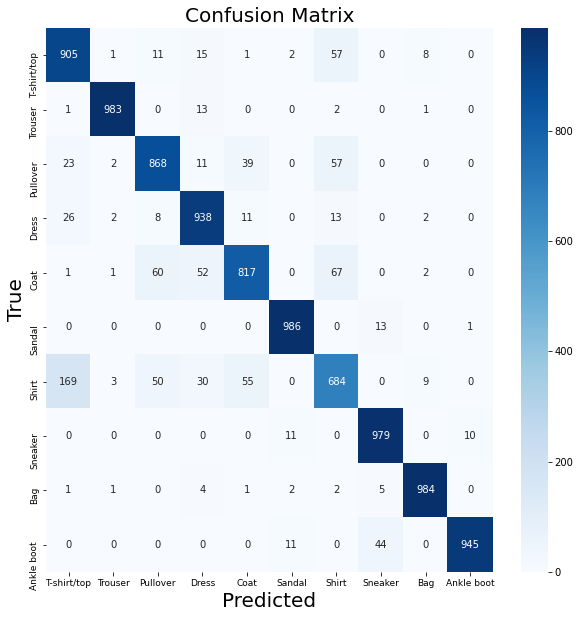

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = torch.zeros(len(train_set.targets.unique()), len(train_set.targets.unique()))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
cm = confusion_matrix.numpy()

fig,ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f',cmap='Blues')
ax.set_xlabel('Predicted', size=20);
ax.set_ylabel('True', size=20);
ax.set_title('Confusion Matrix', size=20);
ax.xaxis.set_ticklabels([train_set.classes[0],train_set.classes[1],train_set.classes[2],train_set.classes[3], train_set.classes[4], train_set.classes[5],train_set.classes[6], train_set.classes[7], train_set.classes[8], train_set.classes[9]], size=9); \
ax.yaxis.set_ticklabels([train_set.classes[0],train_set.classes[1],train_set.classes[2],train_set.classes[3], train_set.classes[4], train_set.classes[5],train_set.classes[6], train_set.classes[7], train_set.classes[8], train_set.classes[9]], size=9);

In [ ]:
'''
The confusion matrix above shows that the model does fairly
well for the class of T-shirt/top. The most common mistake that
the model made here is that it sometimes wrongly predicted a T-shirt/top to
be a Shirt, which makes sense given the intuitive similarity between the two.
The model did better with the class ofTrouser. The main mistake it made
when given something in this class was to say that it was a Dress, which
is interesting since both of these are pieces of clothing that
cover the bottom half of a person.
When given a Pullover, the model's main mistake was to wrongly
predict that it was either a Coat or a Shirt, which makes intuitive sense,
given that these all cover the top half of a person.
Dresses were sometimes confused as either a T-shirt/top, a Pullover, or a Shirt.
Turning to the Coat, the main mistake that was made here was that the model
sometimes predicted a Coat to be either a Pullover or Shirt, a mistake that does
not seem too surprising.
Sandals, Sneakers, and Ankle boots were sometimes mistaken
for one another, which seems understandable since they are all footwear.
The model performed well on bags, with the most common mistake consisting of
predicting that a Bag was a Dress.
The category that the model struggled most with was a Shirt,
which it sometimes predicted to be either a T-shirt/top, Pullover,
or Coat. This, however, makes intuitive sense given that all three of these are
used to cover a person's top half.
'''